## This script shows how the analysis is done and how plots are created

In [47]:
# import all required modules

%pylab inline

import netCDF4
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

from pathlib import Path

from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree, earth_plot,
    plot_signal_histogram)
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.calibration import (calibrate_sobel)


Populating the interactive namespace from numpy and matplotlib


/home/bathiany/.pyenv/versions/3.5.6/envs/abrupt35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['indices', 'box']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Enter your settings here

In [48]:
###### settings for idealised testcases
data_folder = Path("/home/bathiany/Sebastian/datamining/edges/testcases")
variable = 'test777'     # artificial testcase data
model = "MIROC-ESM"      # CMIP5 model grid also used for testcase
quartile_calibration=4
####


# which month should be selected for the yearly time series (1-12; 13 is annual mean)
month = 4

## smoothing scales
sigma_d = unit('300 km')     # space
sigma_t = unit('10 year')    # time


# select data based on settings above
## No editing below this point required

In [49]:
data_set = DataSet.cmip5(
    path=data_folder,
    model=model, 
    variable=variable,
    scenario='rcp85',      # climate change scenario, here: rcp85
    realization='r1i1p1',  # realisation 
)[month-1::12]

data_set.load()

## Load and inspect the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [50]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(1.0 year, 310.239 km, 312.736 km) per pixel
2006-04-16, 2007-04-16, 2008-04-16,  ...
time steps: max 366.0 min 365.0


The ``Box`` class has the nice feature that you can select slices from it, and the information will adapt. The data we loaded contains monthly snapshots. If we select one snapshot in twelve, we obtain yearly data for that month. The ``Box`` class stores the axis grid points internally and slices the time axis accordingly.

## Calibration

In [51]:
control_set = DataSet.cmip5(
    path=data_folder, model=model, variable=variable,
    scenario='piControl', realization='r1i1p1')[month-1::12]

control_data = control_set.data
control_box = control_set.box

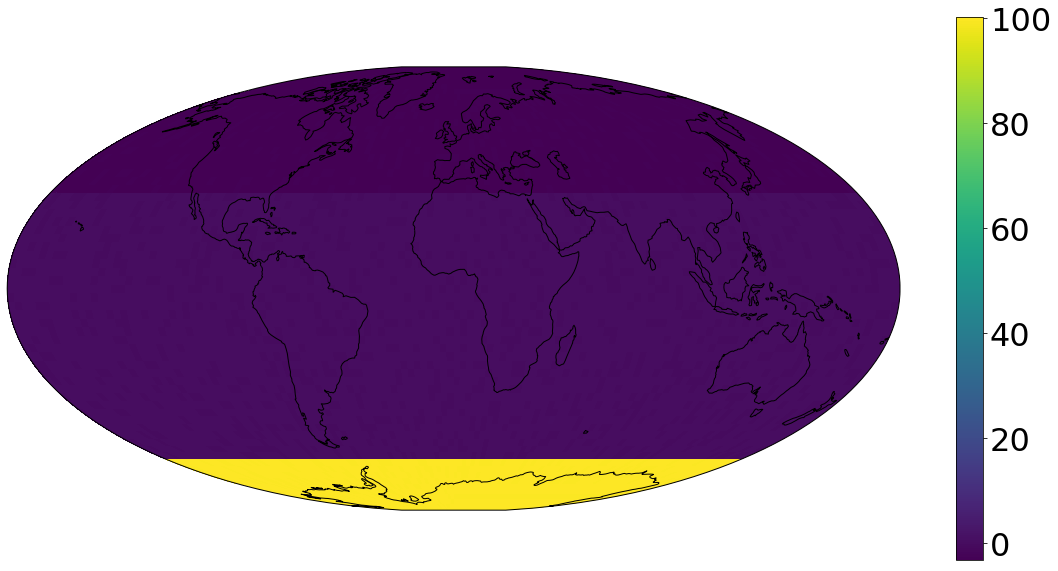

In [52]:
# time mean control data

matplotlib.rcParams.update({'font.size': 32})
meanctl=np.mean(control_data, axis=0)
plot_mollweide(box, meanctl)


In [53]:
# smooth over continental boundaries
taper_masked_area(control_data, [0, 5, 5], 50)

Land-sea mask is empty. No smoothing at coasts is needed.


In [54]:
smooth_control_data = gaussian_filter(control_box, control_data, [sigma_t, sigma_d, sigma_d])

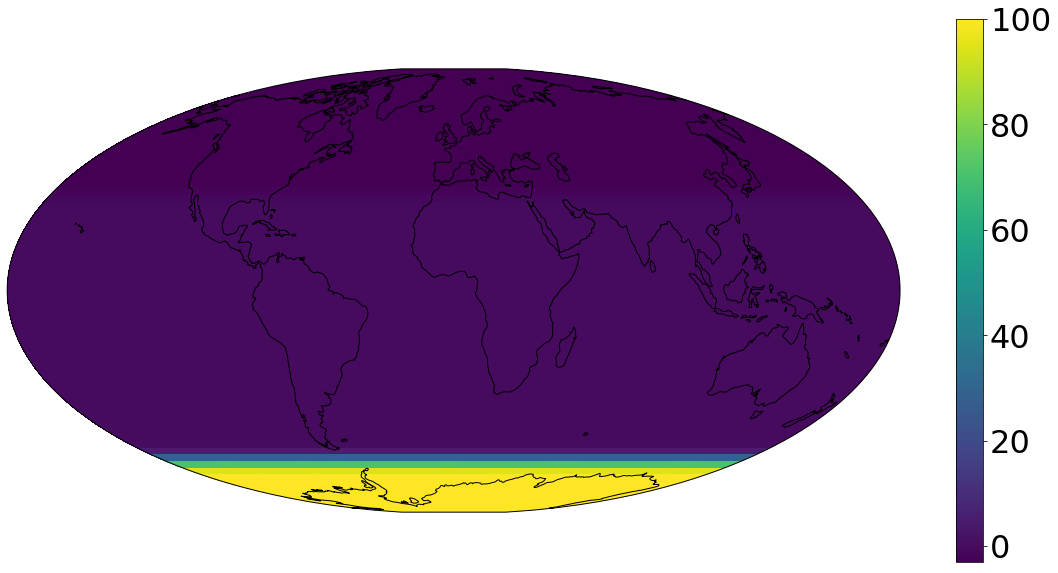

In [55]:
# time mean of smoothed control data
meanctl=np.mean(smooth_control_data, axis=0)
plot_mollweide(box, meanctl)

In [56]:
# scaling_factor is the aspect ratio between space and time
# Here it is initialised as 1, but will be calibrated automatically later
scaling_factor = unit('1 km/year')
sobel_delta_t = unit('1 year')                    # time scale
sobel_delta_d = sobel_delta_t * scaling_factor    # length scale
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

In [57]:
calibration = calibrate_sobel(quartile_calibration, control_box, smooth_control_data, sobel_delta_t, sobel_delta_d)

for k, v in calibration.items():
    print("{:10}: {}".format(k, v))
print("recommended setting for gamma: ", calibration['gamma'][quartile_calibration])   #orig: 3

distance  : [3.8448115e-07 1.3652295e-04 2.2648412e-04 4.0564296e-04 2.1141461e-01]
magnitude : [3.03653695e-12 2.39608062e-06 1.20748555e-05 3.95946772e-05
 5.62977698e-03]
gamma     : [ 0.          9.759875   13.708549   13.977852    0.12595668]
time      : [0.         0.00133245 0.00310477 0.00567002 0.02662908]
recommended setting for gamma:  0.12595668


In [58]:
sb_control = sobel_filter(control_box, smooth_control_data, weight=sobel_weights)
pixel_sb_control = sobel_filter(control_box, smooth_control_data, physical=False)
pixel_sb_control[3] = sb_control[3]

signal_control = (1.0 / sb_control[3])

In [59]:
gamma_cal = calibration['gamma'][quartile_calibration]   #default in hypercc: 3

scaling_factor = gamma_cal * unit('1 km/year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]


In [60]:
## gradients in physical units

# space gradient in K / km
sgrad_phys = np.sqrt(sb_control[1]**2 + sb_control[2]**2) / sb_control[3]

# time gradient in K / year
tgrad = sb_control[0]/sb_control[3]   

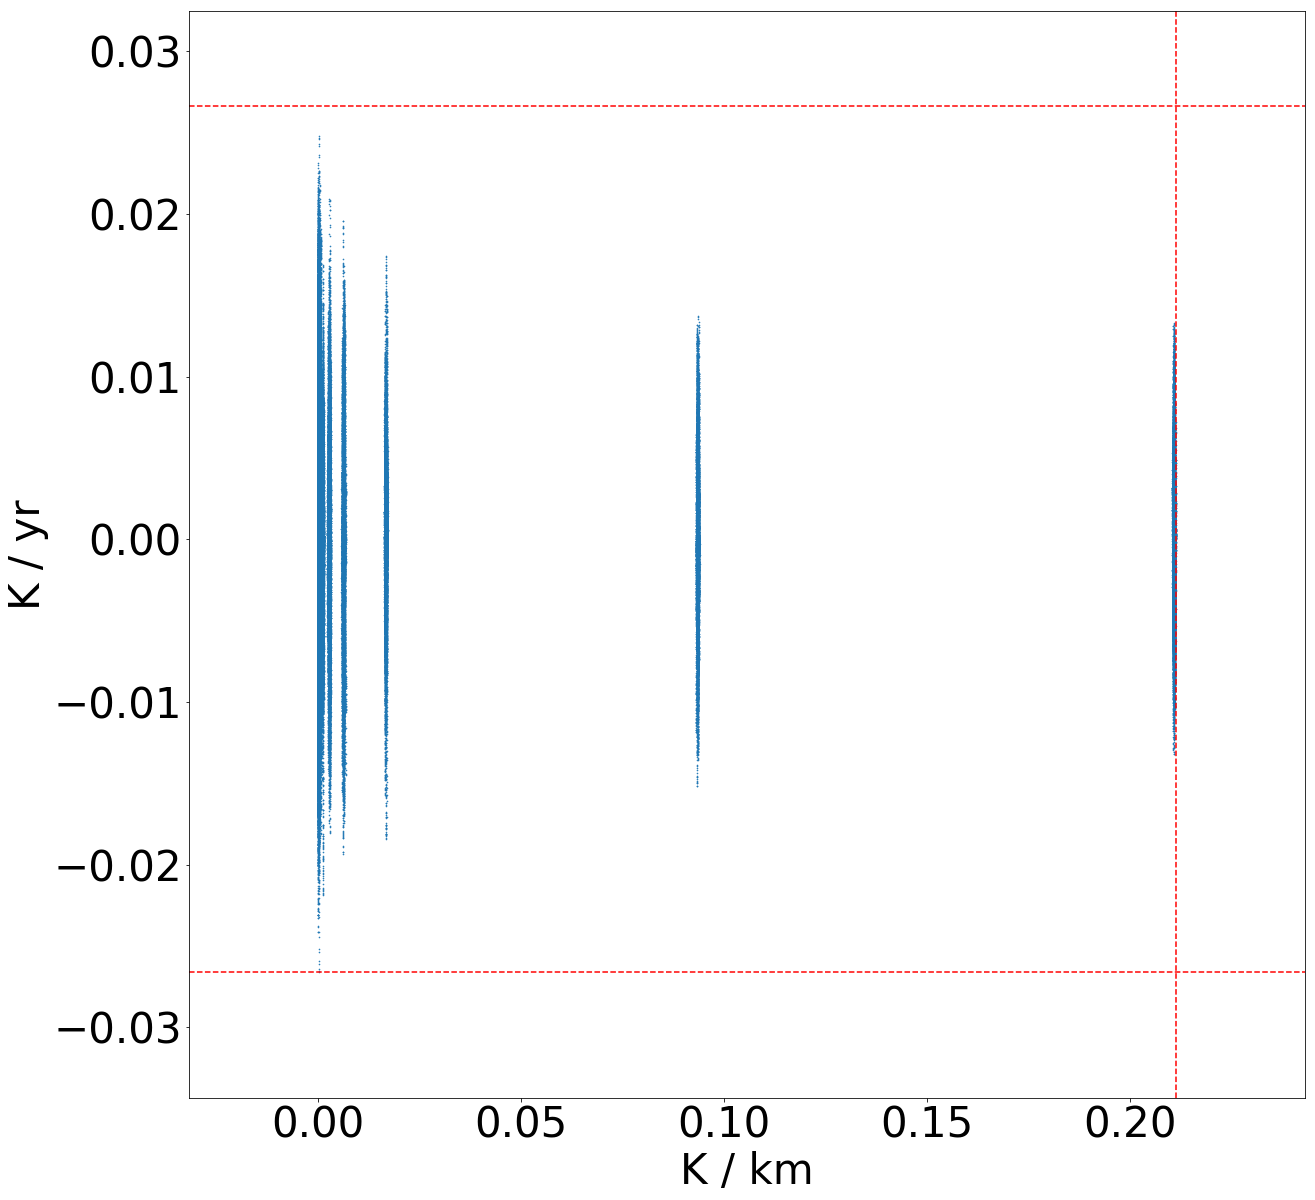

In [69]:
##### scatter diagram of gradients in piControl

matplotlib.rcParams['figure.figsize'] = (20, 20)

#matplotlib.rcParams['figure.figsize'] = (20, 20)
#matplotlib.rcParams.update({'font.size': 40})
#matplotlib.rc('xtick', labelsize=30) 
#matplotlib.rc('ytick', labelsize=30) 

## scatter plot of gradients in space and time:
plt.scatter(sgrad_phys, tgrad, s=1.5, marker = '.');

plt.xlabel('K / km', fontsize=42)
plt.ylabel('K / yr', fontsize=42)
plt.tick_params(axis='both', which='major', labelsize=42)


#### set axis ranges
border=0.15
Smin=np.min(sgrad_phys)-(np.max(sgrad_phys)-np.min(sgrad_phys))*border
Smax=np.max(sgrad_phys)+(np.max(sgrad_phys)-np.min(sgrad_phys))*border
Tmin=np.min(tgrad)-(np.max(tgrad)-np.min(tgrad))*border
Tmax=np.max(tgrad)+(np.max(tgrad)-np.min(tgrad))*border


plt.xlim(Smin, Smax)
plt.ylim(Tmin, Tmax)

## max space gradient (4th quartile)
plt.axvline(x=np.max(sgrad_phys), ymin=0, ymax=1, color='r', linestyle="--")

## max time gradient
plt.axhline(xmin=0, xmax=1, y=np.max(np.abs(tgrad)), color='r', linestyle="--")
plt.axhline(xmin=0, xmax=1, y=-np.max(np.abs(tgrad)), color='r', linestyle="--")

## selected quartile (same as max in this case)
#plt.axvline(x=calibration['distance'][quartile_calibration], ymin=0, ymax=1, color='g', linestyle="--")
#plt.axhline(xmin=0, xmax=1, y=calibration['time'][quartile_calibration], color='g', linestyle="--")
#plt.axhline(xmin=0, xmax=1, y=-calibration['time'][quartile_calibration], color='g', linestyle="--")



In [62]:
## defining the threshold parameters for hysteresis thresholding:
# each pixel with a the gradient above the upper threshold is labeled as a strong edge.
# each pixel that is above the lower threshold is labeled as a weak edge.
# all strong edges are kept as edges.
# all weak edges that are connected to strong edges are kept as edges, the others are dropped.

# set upper threshold as the combination of the maxima of gradients in space and time
mag_quartiles=np.sqrt((calibration['distance'] * gamma_cal)**2 + calibration['time']**2)
upper_threshold = mag_quartiles[4]

# set lower threshold to be half the upper threshold
lower_threshold = upper_threshold/2

In [17]:
## equivalent space gradient in °C / yr (scaling_factor is in kilometer/year)

sgrad_scaled = sgrad_phys * gamma_cal                   # K/km * km/yr => K/yr

In [18]:
## now, the moment of sgrad_scaled that was chosen for calibration is identical to the moment of tgrad
# This means that the green lines in the figure below are at the same value on both axes.
(calibration['distance'][quartile_calibration] * gamma_cal, calibration['time'][quartile_calibration])

(0.026629083, 0.026629083)

(-0.035, 0.035)

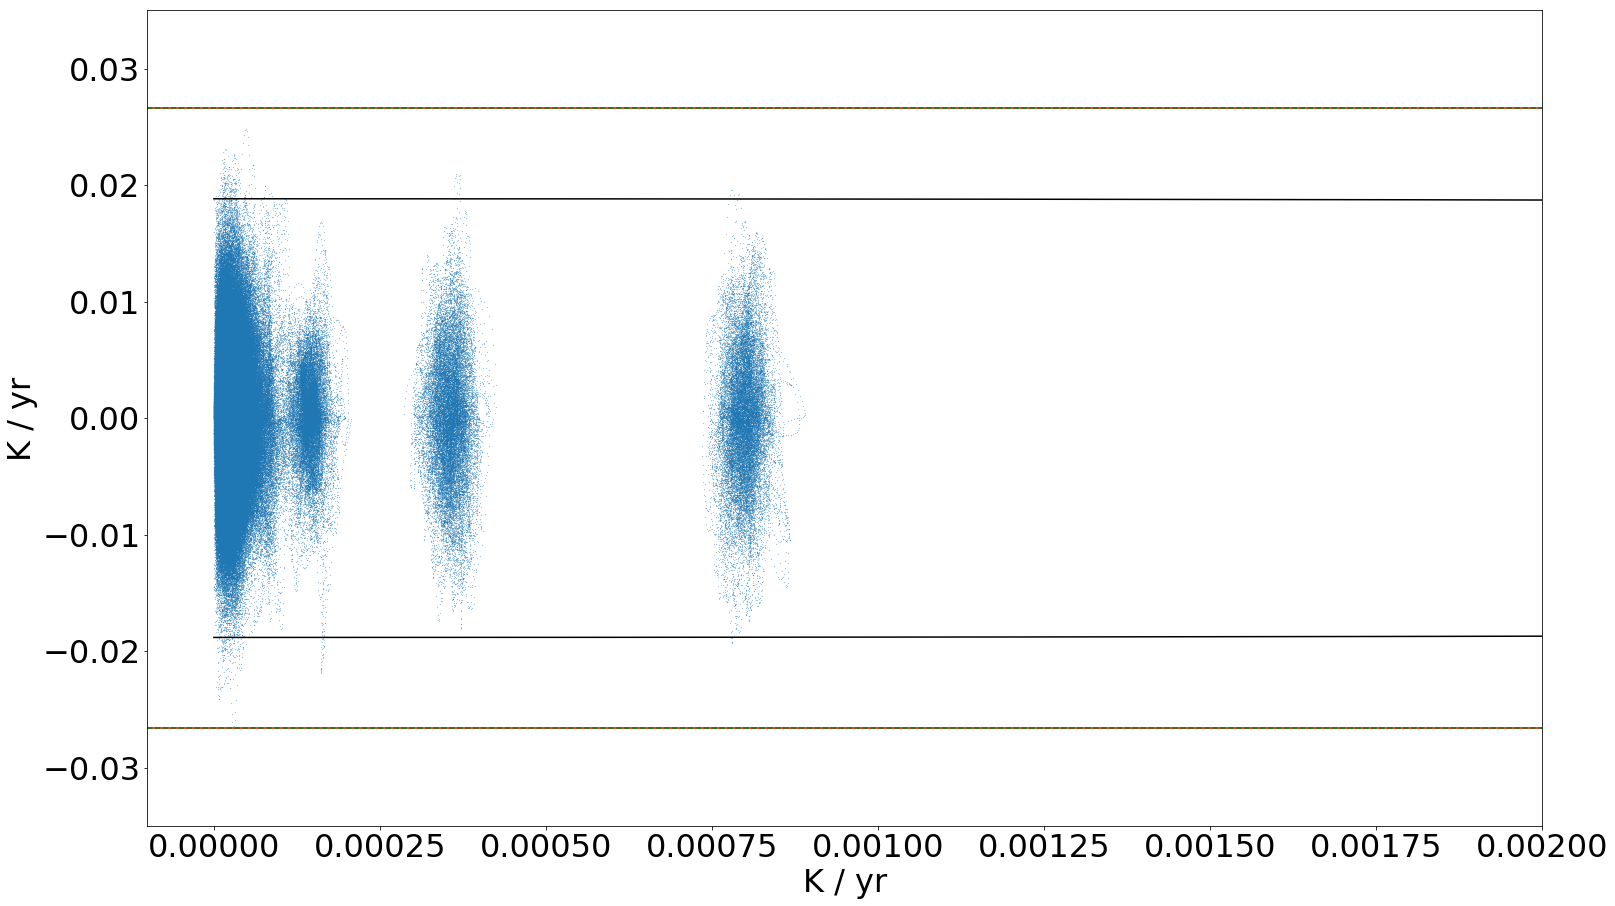

In [19]:
##### scatter diagram of gradients in piControl as calibrated units

matplotlib.rcParams['figure.figsize'] = (25, 15)

## scatter plot of gradients in space and time:
plt.scatter(sgrad_scaled, tgrad, s=0.1, marker = '.');

#matplotlib.rcParams.update({'font.size': 40})

plt.xlabel('K / yr', fontsize=32)
plt.ylabel('K / yr', fontsize=32)

plt.tick_params(axis='both', which='major', labelsize=32)
matplotlib.rcParams.update({'font.size': 32})

## max space gradient (rescaled)
plt.axvline(x=np.max(sgrad_scaled), ymin=0, ymax=1, color='r', linestyle="-")

## max time gradient
plt.axhline(xmin=0, xmax=1, y=np.max(np.abs(tgrad)), color='r', linestyle="-")
plt.axhline(xmin=0, xmax=1, y=-np.max(np.abs(tgrad)), color='r', linestyle="-")

# quartiles
plt.axvline(x=calibration['distance'][quartile_calibration]*gamma_cal, ymin=0, ymax=1, color='g', linestyle="--")
plt.axhline(xmin=0, xmax=1, y=calibration['time'][quartile_calibration], color='g', linestyle="--")
plt.axhline(xmin=0, xmax=1, y=-calibration['time'][quartile_calibration], color='g', linestyle="--")


#### circle showing the threshold values of hysteresis thresholding
dp = np.linspace(-np.pi/2, np.pi/2, 100)

radius=upper_threshold
dt = radius * sin(dp)
dx = radius * cos(dp) 
plt.plot(dx, dt, c='k')

## circle showing the lower threshold:
radius=lower_threshold
dt = radius * sin(dp)
dx = radius * cos(dp)
plt.plot(dx, dt, c='k') 
                 

#### set axis ranges
border=0.15
Smin=np.min(sgrad_phys)-(np.max(sgrad_phys)-np.min(sgrad_phys))*border
Smax=np.max(sgrad_phys)+(np.max(sgrad_phys)-np.min(sgrad_phys))*border
Tmin=np.min(tgrad)-(np.max(tgrad)-np.min(tgrad))*border
Tmax=np.max(tgrad)+(np.max(tgrad)-np.min(tgrad))*border

#### set axis ranges (adjusted to this specific example)

#Smin=-0.001
#Smax=0.013
#Tmin=-0.013
#Tmax=0.013


#Smin=-0.001
#Smax=0.007
#Tmin=-0.007
#Tmax=0.007

Smin=-0.0001
Smax=0.002
Tmin=-0.035
Tmax=0.035


plt.xlim(Smin, Smax)
plt.ylim(Tmin, Tmax)


(-0.035, 0.035)

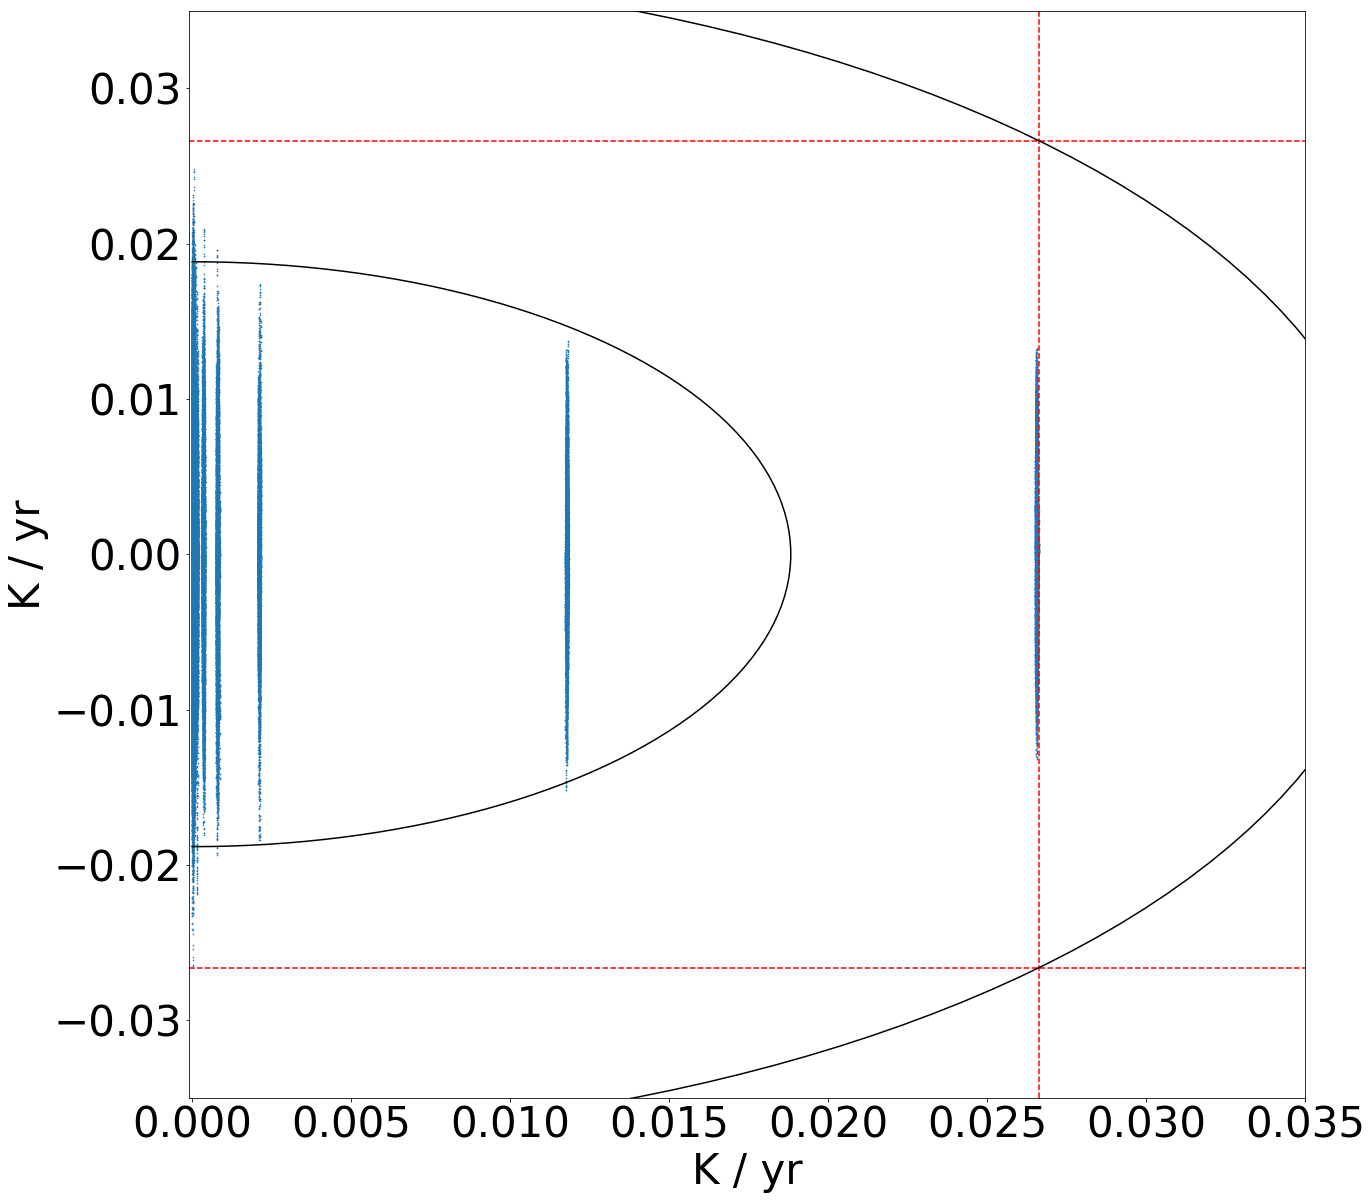

In [70]:
##### scatter diagram of gradients in piControl as calibrated units

matplotlib.rcParams['figure.figsize'] = (20, 20)

## scatter plot of gradients in space and time:
plt.scatter(sgrad_scaled, tgrad, s=1.5, marker = '.');

#matplotlib.rcParams.update({'font.size': 40})

plt.xlabel('K / yr', fontsize=42)
plt.ylabel('K / yr', fontsize=42)

plt.tick_params(axis='both', which='major', labelsize=42)
matplotlib.rcParams.update({'font.size': 42})

## max space gradient (rescaled)
plt.axvline(x=np.max(sgrad_scaled), ymin=0, ymax=1, color='r', linestyle="--")

## max time gradient
plt.axhline(xmin=0, xmax=1, y=np.max(np.abs(tgrad)), color='r', linestyle="--")
plt.axhline(xmin=0, xmax=1, y=-np.max(np.abs(tgrad)), color='r', linestyle="--")



#### circle showing the threshold values of hysteresis thresholding
dp = np.linspace(-np.pi/2, np.pi/2, 100)

radius=upper_threshold
dt = radius * sin(dp)
dx = radius * cos(dp) 
plt.plot(dx, dt, c='k')

## circle showing the lower threshold:
radius=lower_threshold
dt = radius * sin(dp)
dx = radius * cos(dp)
plt.plot(dx, dt, c='k') 
                 

#### set axis ranges
border=0.15
Smin=np.min(sgrad_phys)-(np.max(sgrad_phys)-np.min(sgrad_phys))*border
Smax=np.max(sgrad_phys)+(np.max(sgrad_phys)-np.min(sgrad_phys))*border
Tmin=np.min(tgrad)-(np.max(tgrad)-np.min(tgrad))*border
Tmax=np.max(tgrad)+(np.max(tgrad)-np.min(tgrad))*border

#### set axis ranges (adjusted to this specific example)

#Smin=-0.001
#Smax=0.013
#Tmin=-0.013
#Tmax=0.013


#Smin=-0.001
#Smax=0.007
#Tmin=-0.007
#Tmax=0.007

Smin=-0.0001
Smax=0.035
Tmin=-0.035
Tmax=0.035


plt.xlim(Smin, Smax)
plt.ylim(Tmin, Tmax)


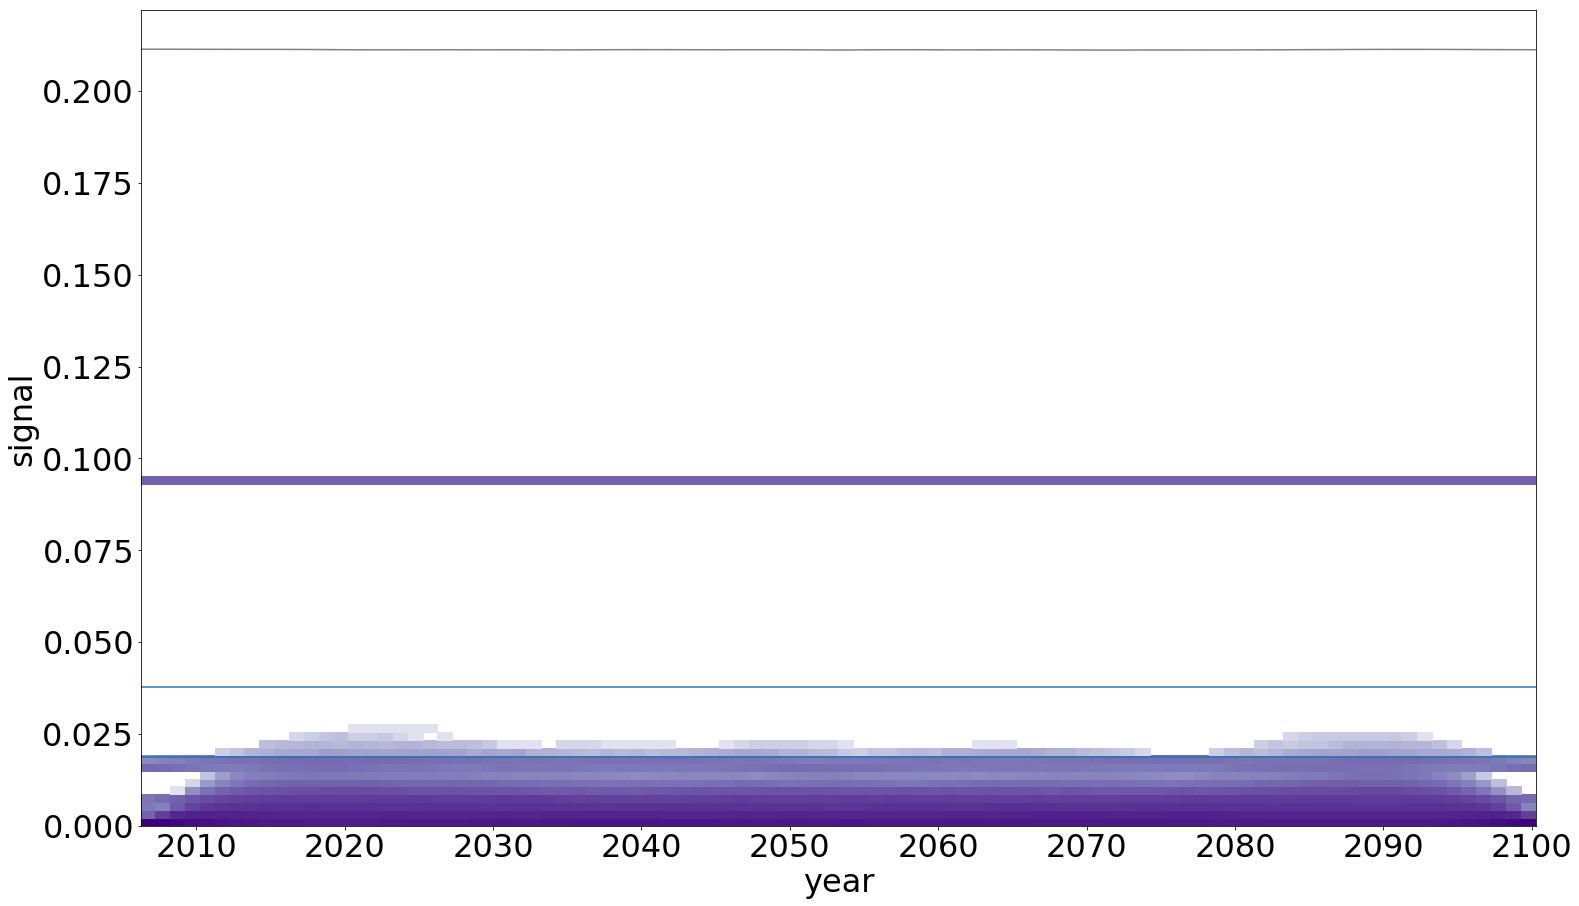

In [21]:
plot_signal_histogram(control_box, signal_control, upper_threshold, lower_threshold);

matplotlib.rcParams.update({'font.size': 32})

## Canny edges

The Canny edge detector consists of four stages:

* Smoothing
* Differentiating (Sobel operator)
* Non-maximum suppression
* Hysteresis thresholding

The first two of these stages are sensitive to the geometry of the information. How data is smoothed or differentiated is influenced by the spherical projection of our data. In this method we assume a Plate-Carree projection, where lattitudes and longitudes are mapped to a 1:2 rectangle with equal number of degrees per pixel everywhere. We may test this assumption on our ``box`` object.

In [22]:
box.rectangular

True

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [23]:
data = data_set.data
yearly_box = box[month-1::12]

# smooth over continental boundaries
taper_masked_area(data, [0, 5, 5], 50)    
# smoothing is not applied in time, 5 grid boxes wide in space (lat and lon), iteration: 50 times

smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])


Land-sea mask is empty. No smoothing at coasts is needed.


### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [24]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)
pixel_sb[3] = sb[3]

### Determine hysteresis settings

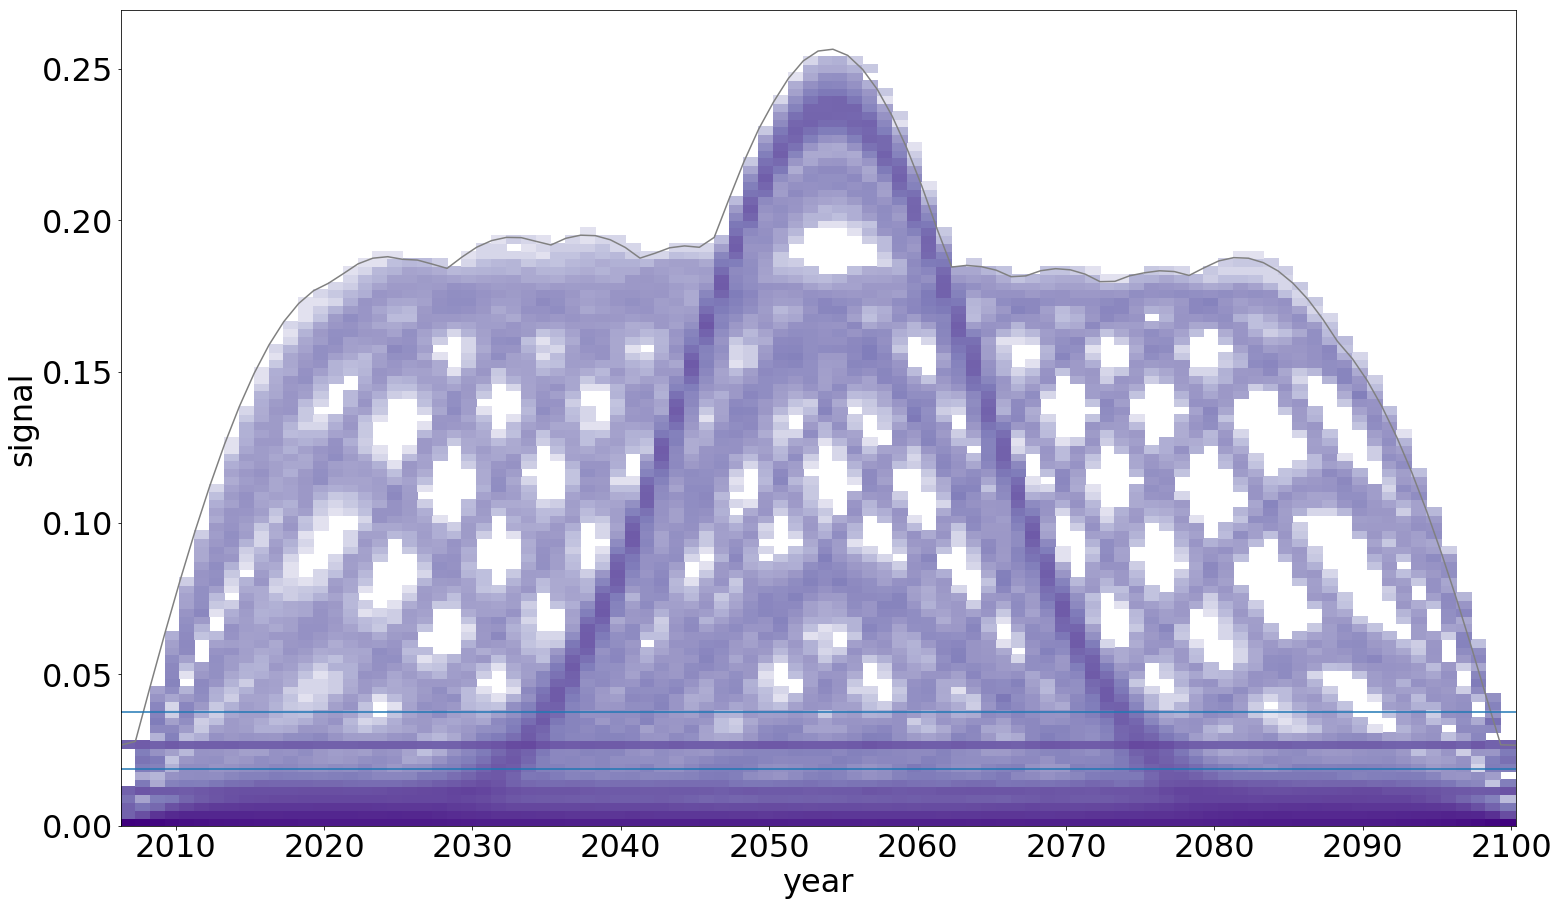

In [25]:
signal = (1.0 / sb[3])

plot_signal_histogram(box, signal, upper_threshold, lower_threshold);

matplotlib.rcParams.update({'font.size': 32})

In [26]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [27]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy()

In [28]:
thinned *= ~data.mask
thinned[:10] = 0
thinned[-10:] = 0

In [29]:
## edge thinning
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])

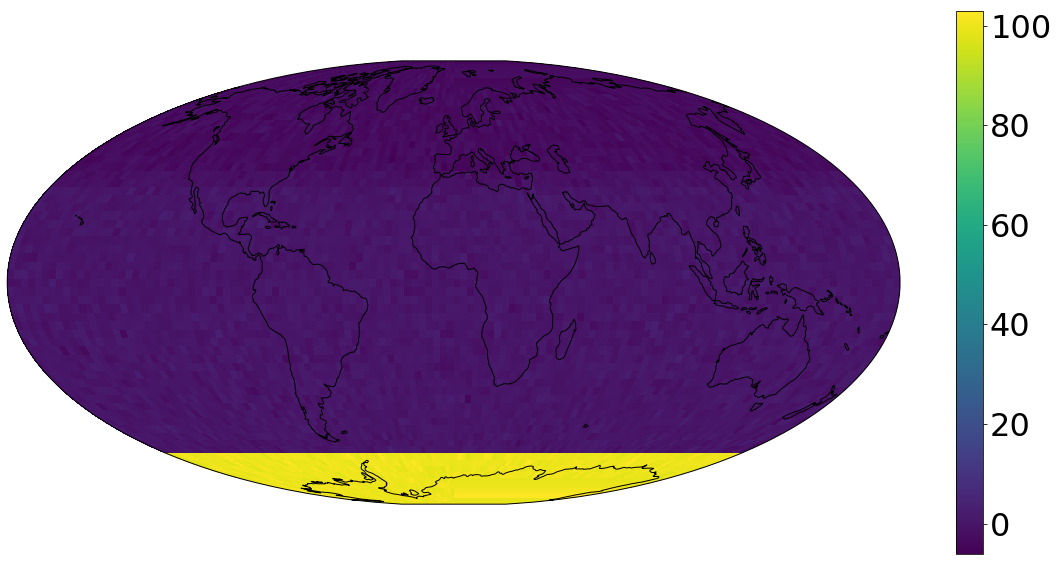

In [30]:
## a first look at the data (first time step)

plot_mollweide(box, data_set.data[0])

In [31]:
## define colour scale for plotting with white where variable is 0

my_cmap = matplotlib.cm.get_cmap('rainbow')
matplotlib.rcParams['figure.figsize'] = (25,10)
my_cmap.set_under('w')

113
[1, 7, 15, 57, 62, 68, 69, 70, 71]


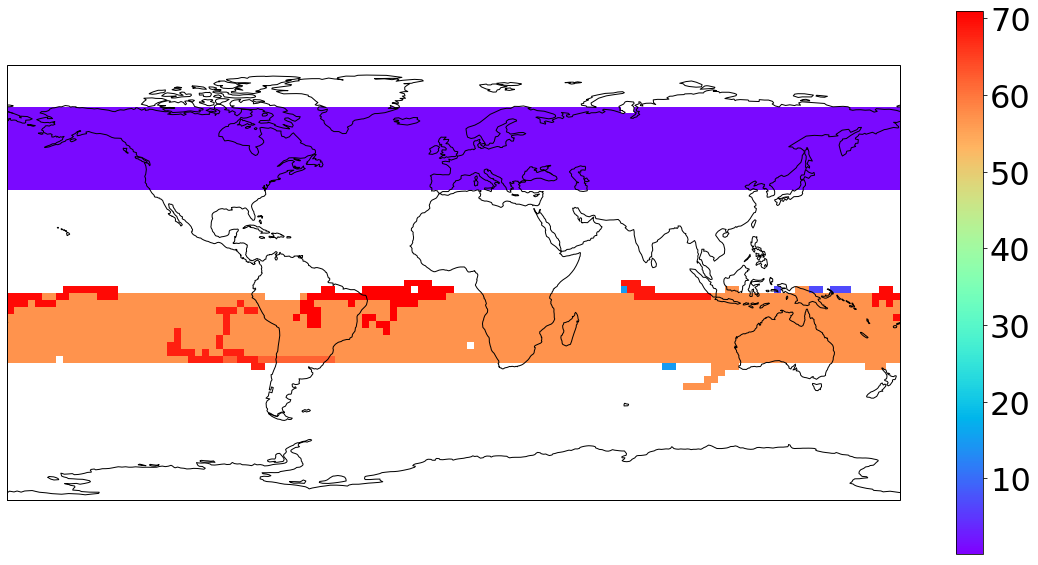

In [32]:
labels, n_features = ndimage.label(m, ndimage.generate_binary_structure(3, 3))
print(n_features)
big_enough = [x for x in range(1, n_features+1) if (labels==x).sum() > 100]
print(big_enough)
labels = np.where(np.isin(labels, big_enough), labels, 0)

plot_plate_carree(yearly_box, labels.max(axis=0), cmap=my_cmap, vmin=0.1)

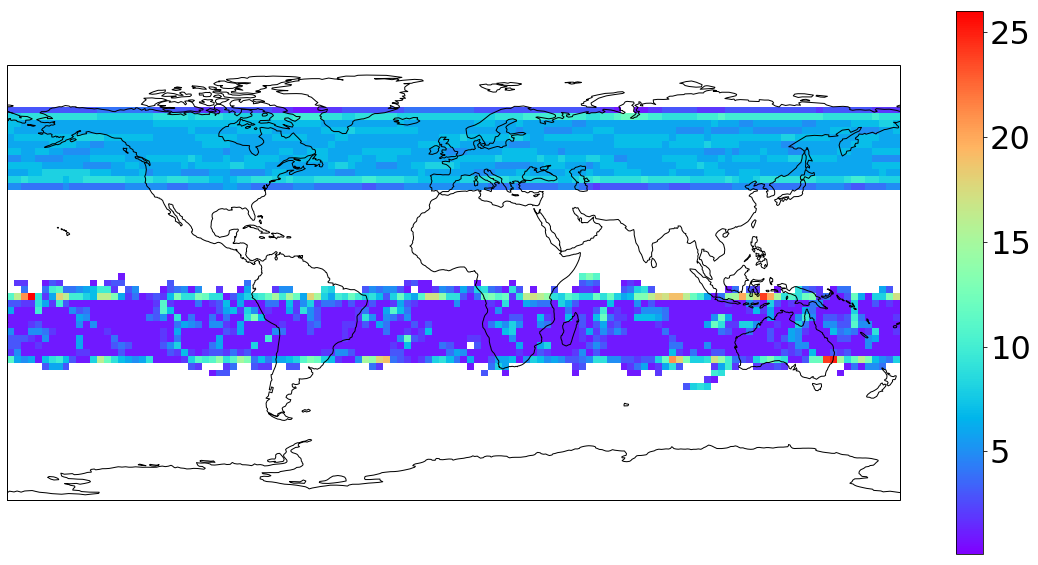

In [33]:
## event count plot: how many years are part of an edge at each grid cell?

plot_plate_carree(yearly_box, np.sum(m, axis=0), cmap=my_cmap, vmin=0.1)

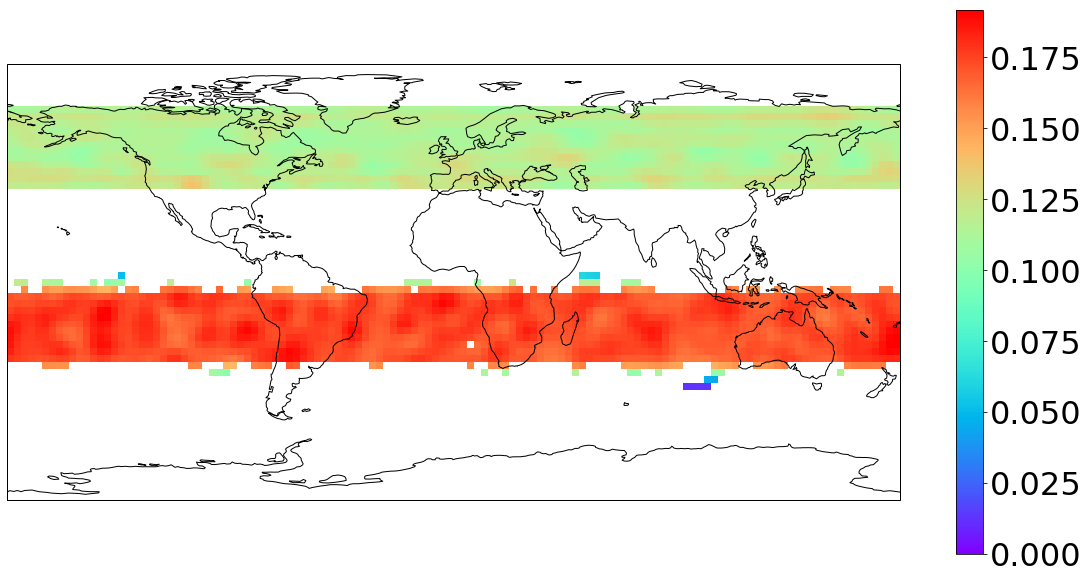

In [34]:
## calculate maximum time gradient at each grid cell (after removing the mean trend)

tgrad=sb[0]/sb[3]
maxm=np.nanmax(m, axis=0)

tgrad_residual = tgrad - np.mean(tgrad, axis=0)   # remove time mean
maxTgrad = np.max(abs(tgrad_residual), axis=0)    # maximum of time gradient
maxTgrad = maxTgrad * maxm

plot_plate_carree(box, maxTgrad, cmap=my_cmap, vmin=1e-30)

## quantifying the abruptness in time on the edges:

In [35]:
cutoff_length=2  # to either side, min should be 1
chunk_max_length=30
chunk_min_length=15
from scipy import stats

In [36]:
years = np.array([d.year for d in box.dates])
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])
idx = np.where(m)
indices=np.asarray(idx)
abruptness3d=m*1.0

shapeidx=np.shape(idx)
nofresults=shapeidx[1]

for result in range(nofresults):
    [dim0,dim1,dim2]=indices[:,result]

    if m[dim0, dim1, dim2] == 1:
        index=dim0
        chunk1_data=data[0:index-cutoff_length,dim1,dim2]
        chunk2_data=data[index+cutoff_length+1:,dim1,dim2]
        chunk1_years=years[0:index-cutoff_length]
        chunk2_years=years[index+cutoff_length+1:]    
            
        if size(chunk1_data) > chunk_max_length:
            chunk1_start=size(chunk1_data)-chunk_max_length
        else:
            chunk1_start=0  
        if size(chunk2_data) > chunk_max_length:
            chunk2_end=chunk_max_length
        else:
            chunk2_end=size(chunk2_data)

        chunk1_data_short=chunk1_data[chunk1_start:]
        chunk2_data_short=chunk2_data[0:chunk2_end]                

        N1=size(chunk1_data_short)
        N2=size(chunk2_data_short)
                
        if not ((N1 < chunk_min_length) or (N2 < chunk_min_length)):
            chunk1_years_short=chunk1_years[chunk1_start:]-years[dim0]
            chunk2_years_short=chunk2_years[0:chunk2_end]-years[dim0]
        
            slope_chunk1, intercept_chunk1, r_value, p_value, std_err = stats.linregress(chunk1_years_short, chunk1_data_short)
            chunk1_regline=intercept_chunk1 + slope_chunk1*chunk1_years_short
            
            slope_chunk2, intercept_chunk2, r_value, p_value, std_err = stats.linregress(chunk2_years_short, chunk2_data_short)
            chunk2_regline=intercept_chunk2 + slope_chunk2*chunk2_years_short
            
            mean_std=(np.nanstd(chunk1_data_short)+np.nanstd(chunk2_data_short))/2
            abruptness3d[dim0,dim1,dim2]=abs(intercept_chunk1-intercept_chunk2)/mean_std
abruptness=np.max(abruptness3d,axis=0)


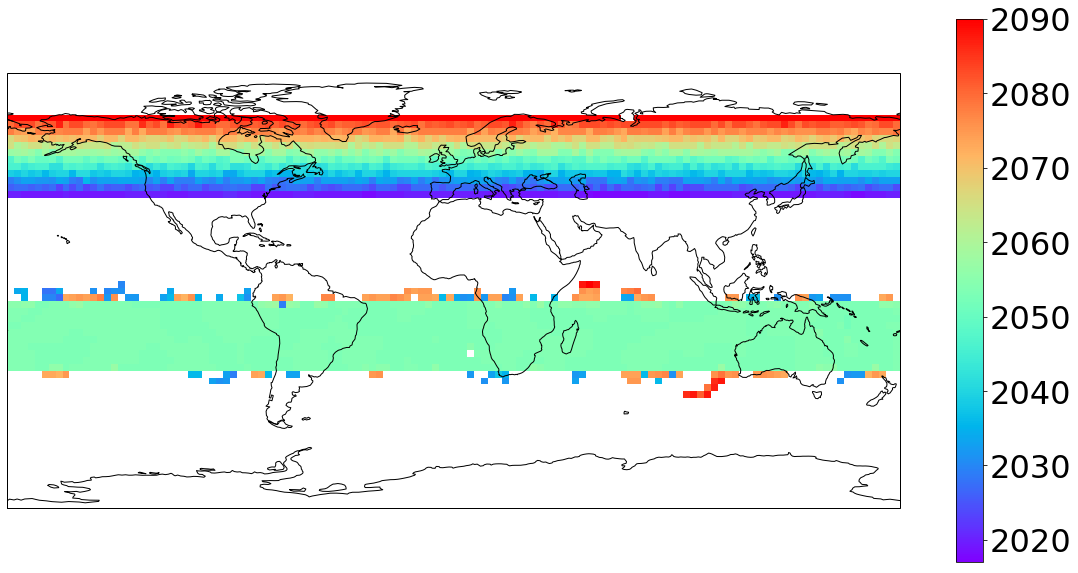

In [37]:
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])
idx = np.where(m)
indices=np.asarray(idx)

mask_max=m*0

shapeidx=np.shape(idx)
nofresults=shapeidx[1]

for result in range(nofresults):
    [dim0,dim1,dim2]=indices[:,result]
    if abruptness3d[dim0, dim1, dim2] == abruptness[dim1,dim2]:
        mask_max[dim0, dim1, dim2] = 1
        
years_maxpeak=(years[:,None,None]*mask_max).max(axis=0)

minval = np.min(years_maxpeak[np.nonzero(years_maxpeak)])
maxval= np.max(years_maxpeak)

#minval,maxval

plot_plate_carree(yearly_box, years_maxpeak,  cmap=my_cmap, vmin=minval, vmax=maxval) #, vmin=2000, vmax=2200)

## Show the time series of the original data at the grid cell with the largest abruptness

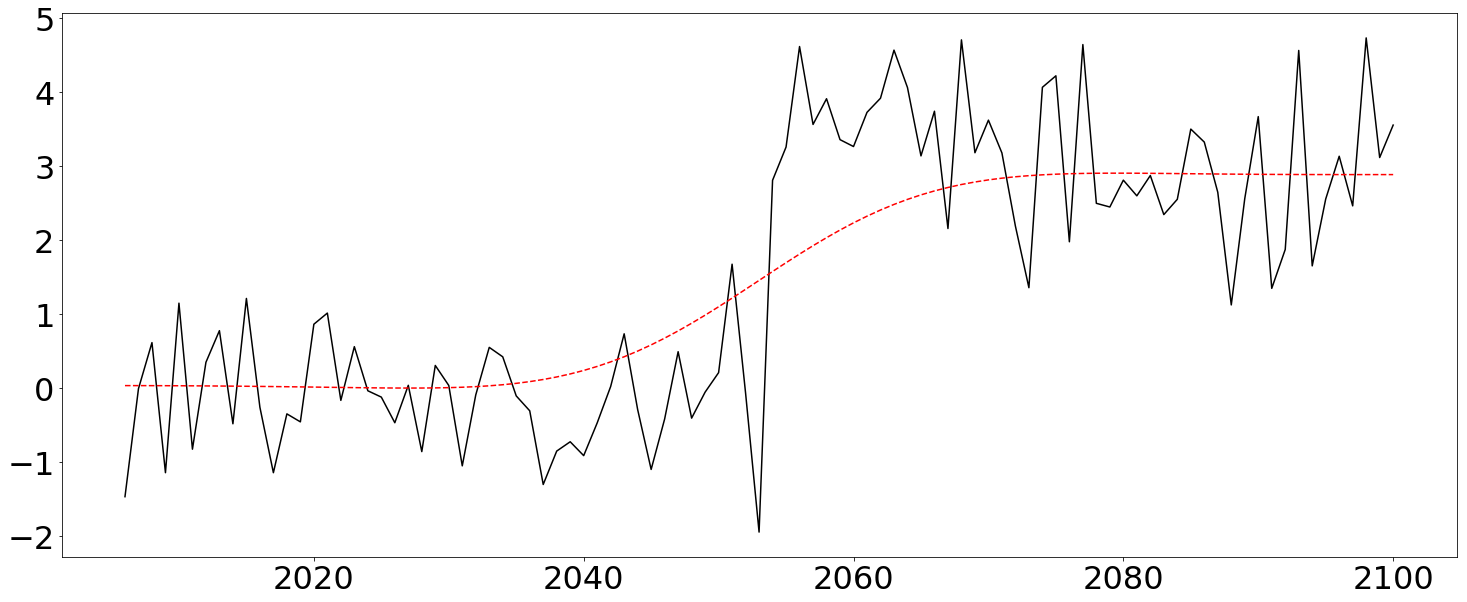

In [38]:
lonind=np.nanargmax(np.nanmax(abruptness, axis=0))
latind=np.nanargmax(np.nanmax(abruptness, axis=1))
ts=data[:,latind,lonind]
ts_smooth=smooth_data[:,latind,lonind]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(years, ts, 'k', years, ts_smooth, 'r--')

In [39]:
## function obtaining the edges, their position in space and time, and the abruptness as measured above

def feature_stats_all(box, m, sb, abruptness3d, years):
    years3d=years[:,None,None]*m
    lats=box.lat
    lats3d=lats[None,:,None]*m
    lons=box.lon
    lons3d=lons[None,None,:]*m
    idx = np.where(m)
    m15 =abruptness3d[idx[0], idx[1], idx[2]]
    years2=years3d[idx[0], idx[1], idx[2]]
    lats2  =lats3d[idx[0], idx[1], idx[2]]
    lons2  =lons3d[idx[0], idx[1], idx[2]]
    sobel  = sb[:, idx[0], idx[1], idx[2]]
    dx = np.sqrt(sobel[1]**2 + sobel[2]**2) * unit('1/year') / scaling_factor
    return {
        'dx': dx/sobel[3],              # space gradient
        'dt': sobel[0]/sobel[3],        # time gradient
        'idx': idx,
        'm15': m15,
        'years2': years2,
        'lats2': lats2,
        'lons2': lons2
    }

## scatter plot of space versus time gradients

In [40]:
## obtain location of edges in space and time, the magnitude of the gradients and their abruptness, and sort them
stats = feature_stats_all(box, m, sb, abruptness3d, years)

sgrad=stats['dx']*1000   # scale to 1000 km
sgrad = sgrad.magnitude
tgrad=stats['dt']*10     # scale to 10 years
abruptness=stats['m15']
years2=stats['years2']
lats2=stats['lats2']
lons2=stats['lons2']

# sort data points in order to show most abrupt ones on top of the others in scatter plot
inds = abruptness.argsort()
sgrad_sorted = sgrad[inds]
tgrad_sorted = tgrad[inds]
abruptness_sorted = abruptness[inds]
years_sorted = years2[inds]
lats_sorted = lats2[inds]
lons_sorted = lons2[inds]

In [41]:
def scatter_gradients(sgrad,tgrad,size,colour, colourbarlabel):
    ## scatter plot of space versus time gradients and their abruptness

    matplotlib.rcParams['figure.figsize'] = (15, 10)

    #### ellipses showing the threshold values of hysteresis thresholding
    dp = np.linspace(-np.pi/2, np.pi/2, 100)

    radius=upper_threshold
    dt = radius * sin(dp) * 10
    dx = radius * cos(dp) / gamma_cal * 1000 ## convert back from time to space units

    # ellipse showing the aspect ratio. for scaling_factor=1 would be a circle
    # the radius of that circle is the upper threshold
    plt.plot(dx, dt, c='k')

    ## ellipse based on the lower threshold:
    radius=lower_threshold
    dt = radius * sin(dp) * 10
    dx = radius * cos(dp)  / gamma_cal  *1000
    plt.plot(dx, dt, c='k') 
                 
    ## scatter plot, weighted with abruptness:
    plt.scatter(sgrad, tgrad,s=size**2,c=colour, marker = 'o', cmap =my_cmap );
    cbar=plt.colorbar()
    cbar.set_label(colourbarlabel)

    #matplotlib.rcParams.update({'font.size': 40})

    plt.xlabel('1 K / 1000 km', fontsize=32)
    plt.ylabel('1 K / decade', fontsize=32)


    plt.tick_params(axis='both', which='major', labelsize=32)
    
    # Show typical speed of spatial gradients (expanding climate zone) in data: 
    Lvec = np.linspace(0,5,100)
    Tvec = np.linspace(0,10,100)
    plt.plot(Tvec, Lvec, 'k--')
    
    
    #### set axis ranges
    border=0.05
    Smin=np.min(sgrad)-(np.max(sgrad)-np.min(sgrad))*border
    Smax=np.max(sgrad)+(np.max(sgrad)-np.min(sgrad))*border
    Tmin=np.min(tgrad)-(np.max(tgrad)-np.min(tgrad))*border
    Tmax=np.max(tgrad)+(np.max(tgrad)-np.min(tgrad))*border

    Smin=0
    Smax=5
    
    Tmin=0
    Tmax=2.7
    
    
    plt.xlim(Smin, Smax)
    plt.ylim(Tmin, Tmax)


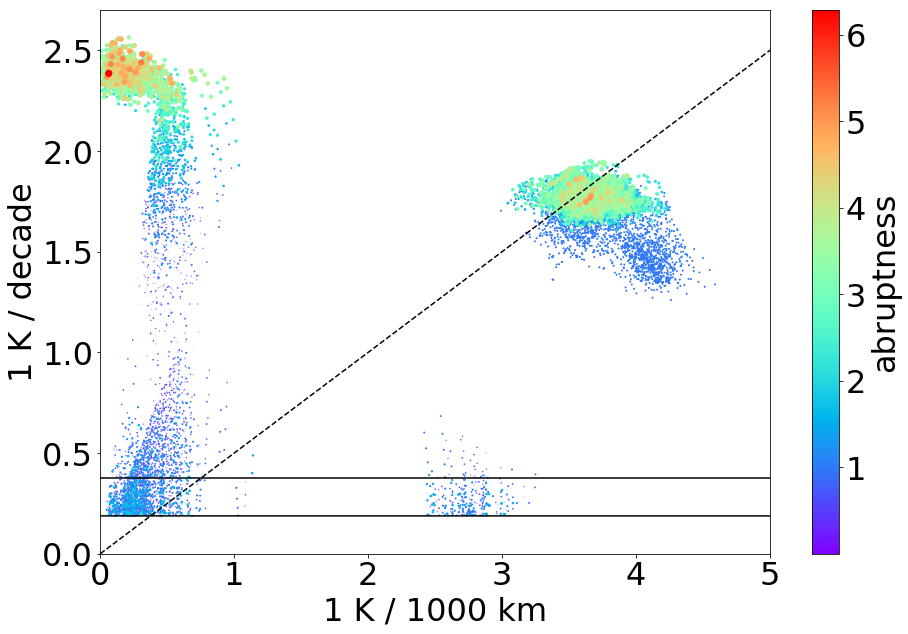

In [42]:
## scatter plot of space versus time gradients and their abruptness
scatter_gradients(sgrad_sorted, tgrad_sorted,abruptness_sorted,abruptness_sorted,'abruptness')

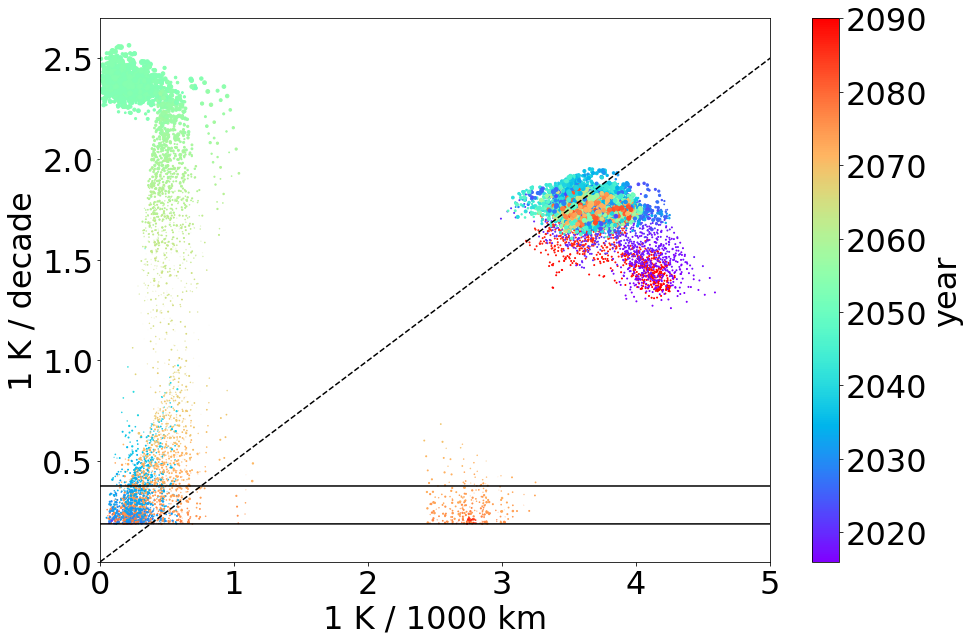

In [43]:
## same but color coding with years
scatter_gradients(sgrad_sorted, tgrad_sorted,abruptness_sorted,years_sorted,'year')

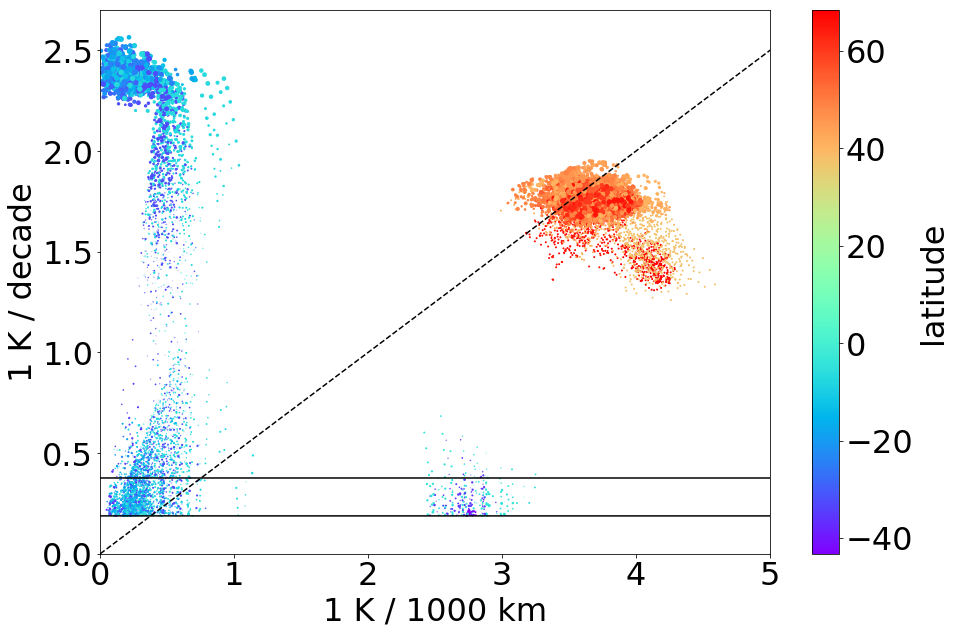

In [44]:
## same but color coding with latitudes
scatter_gradients(sgrad_sorted, tgrad_sorted,abruptness_sorted,lats_sorted,'latitude')

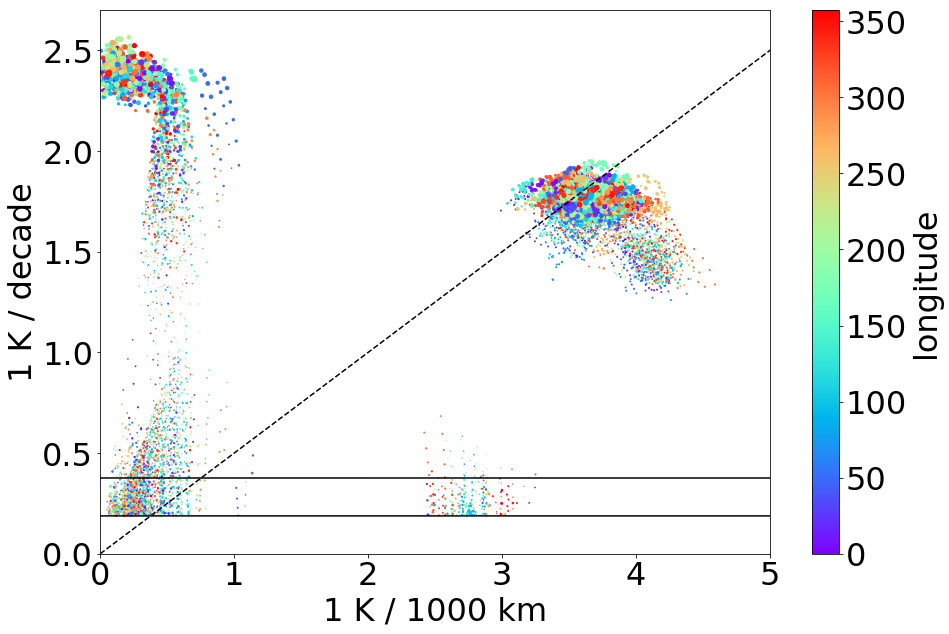

In [45]:
## same but color coding with longitudes
scatter_gradients(sgrad_sorted, tgrad_sorted,abruptness_sorted,lons_sorted,'longitude')